In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from dpa import attacker
from matplotlib.patches import Polygon
from scipy.stats import norm
from tensorflow_privacy.privacy.analysis.rdp_accountant \
    import compute_rdp, get_privacy_spent
from scipy.stats import norm

adversary = attacker.GaussianAttacker()

/Users/d052098/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
rho = 0.99
eps = np.log(rho/(1-rho))
print(eps)
#eps = 4.6
delt = 0.001

print(2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1)

4.595119850134589
0.45706897038216643


In [3]:
def load_pickle(directory, filename):
    with np.load(os.path.join(directory, filename), allow_pickle=True) as data:
        return data['run_0'].item()

def load_results(experiment_path, rho, dlt):
    results = []
    for dirpath, dirnames, filenames in os.walk(experiment_path):
        for filename in [f for f in filenames if not f[0] == '.']:    
            results.append(load_pickle(dirpath, filename))
    return results

In [4]:
DLT = 0.001
RHO = 0.9

results = []
results = load_results("../experiments/adult/min_max_manh/min", RHO, DLT)
runs = len(results)
sensitivities_min_manh = [result['sensitivites'] for result in results]
max_biased_beliefs_manh_min = [result['biased_beliefs'][0][-1] for result in results]

results = []
results = load_results("../experiments/adult/min_max_manh/max", RHO, DLT)
runs = len(results)
sensitivities_max_manh = [result['sensitivites'] for result in results]
max_biased_beliefs_manh_max = [result['biased_beliefs'][0][-1] for result in results]

success_rate_empir_min = sum(bias_belief > 0.5 for bias_belief in max_biased_beliefs_manh_min)
success_rate_empir_max = sum(bias_belief > 0.5 for bias_belief in max_biased_beliefs_manh_max)

epochs=30
epsilon = adversary.get_epsilon_for_confidence_bound(RHO)
success_rate = adversary.expected_rdp_success_rate(adversary.get_noise_multiplier_for_rdp_eps(epsilon, DLT, epochs), epochs)

print("success rate ", success_rate-(1-success_rate))
print(f"Empirical advantage min:{success_rate_empir_min/runs-(1-success_rate_empir_min/runs)}")
print(f"Empirical advantage max:{success_rate_empir_max/runs-(1-success_rate_empir_max/runs)}")

<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fd0c175d320>
changed
success rate  0.2168295024673812
Empirical advantage min:-0.9967999999999999
Empirical advantage max:0.17920000000000003


In [5]:
DLT = 0.001
RHO = 0.9

def load_results(experiment_path, rho, dlt):
    results = []
    for dirpath, dirnames, filenames in os.walk(experiment_path):
        for filename in [f for f in filenames]:    
            results.append(load_pickle(dirpath, filename))
    return results

adult_dict = {}

to_evaluate = ["rho_53_local_bound", 'rho_53_global_bound', "rho_75_local_bound", "rho_75_global_bound", "rho_90_local_bound", "rho_90_global_bound", "rho_99_local_bound", "rho_99_global_bound", "rho_53_local_unbound", 'rho_53_global_unbound', "rho_75_local_unbound", "rho_75_global_unbound", "rho_90_local_unbound", "rho_90_global_unbound", "rho_99_local_unbound", "rho_99_global_unbound"]

for directory in to_evaluate:
    results = load_results(f"../experiments/adult/min_max_manh/{directory}", RHO, DLT)
    
    print(directory)
    
    runs = len(results)
    print(runs)
    adult_dict[f'sensitivities_{directory}'] = [result['sensitivites'] for result in results]
    adult_dict[f'max_biased_beliefs_adult_{directory}'] = [result['biased_beliefs'][0][-1] for result in results]
    adult_dict[f'train_acc_adult_{directory}'] = [result['train_acc'][-1] for result in results]
    adult_dict[f'acc_{directory}'] = [result['test_acc'][-1] for result in results]

    success_rate_empir = sum(bias_belief > 0.5 for bias_belief in adult_dict[f'max_biased_beliefs_adult_{directory}'])
    adult_dict[f'advantage_adult_{directory}'] = success_rate_empir/runs-(1-success_rate_empir/runs)
    print("advantage ", adult_dict[f'advantage_adult_{directory}'])
    excess_portion = sum(bias_belief > np.round(RHO,2) for bias_belief in adult_dict[f'max_biased_beliefs_adult_{directory}'])
    print(f"Portion of experiments with biased beliefs larger than rho:{excess_portion/runs}")

rho_53_local_bound
1000
advantage  -0.010000000000000009
Portion of experiments with biased beliefs larger than rho:0.0
rho_53_global_bound
1000
advantage  -0.018000000000000016
Portion of experiments with biased beliefs larger than rho:0.0
rho_75_local_bound
1000
advantage  0.12400000000000011
Portion of experiments with biased beliefs larger than rho:0.0
rho_75_global_bound
1000
advantage  0.02400000000000002
Portion of experiments with biased beliefs larger than rho:0.0
rho_90_local_bound
1000
advantage  0.16599999999999993
Portion of experiments with biased beliefs larger than rho:0.0
rho_90_global_bound
1000
advantage  0.1259999999999999
Portion of experiments with biased beliefs larger than rho:0.0
rho_99_local_bound
1000
advantage  0.4059999999999999
Portion of experiments with biased beliefs larger than rho:0.075
rho_99_global_bound
1000
advantage  0.1319999999999999
Portion of experiments with biased beliefs larger than rho:0.0
rho_53_local_unbound
250
advantage  0.08000000000

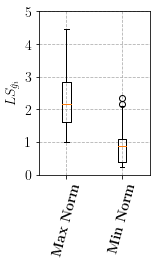

In [6]:
plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 14})

data_to_plot = [np.array(sensitivities_max_manh).flatten(), np.array(sensitivities_min_manh).flatten()]
fig = plt.figure(1, figsize=(2, 3))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_ylim(0,5)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.grid(ls="dashed")
plt.xticks(rotation=75)
ax.set_xticklabels([r'\textbf{Max Norm}', r'\textbf{Min Norm}'])
ax.set_ylabel(r"$LS_{\hat{g}_i}$")
plt.savefig("min_max_distance_adult_sensitivity.pdf", bbox_inches='tight')
plt.show()

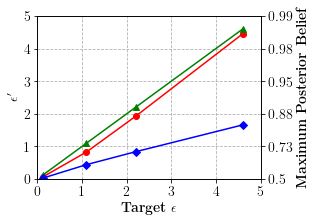

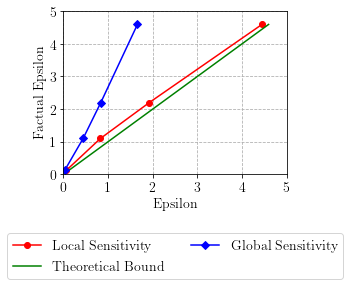

In [9]:
#avg_local = np.amax(purchase_dict[f'max_biased_beliefs_purch_{directory}'])
#avg_global = np.amax(max_biased_beliefs_bounded_global)
matplotlib.rcParams.update({'font.size': 14})

max_beliefs_local = []
max_beliefs_global = []
posterior_evaluate = ["rho_53_local_bound", 'rho_53_global_bound', "rho_75_local_bound", "rho_75_global_bound", "rho_90_local_bound", "rho_90_global_bound", "rho_99_local_bound", "rho_99_global_bound"]

for directory in posterior_evaluate:
    if f"local" in directory:
        max_beliefs_local.append(np.amax(adult_dict[f'max_biased_beliefs_adult_{directory}']))
    else:
        max_beliefs_global.append(np.amax(adult_dict[f'max_biased_beliefs_adult_{directory}']))

rhos = [0.53, .75, .9, .99]
epsilons = [np.log(rho/(1-rho)) for rho in rhos]
rhos_cont = np.arange(0.5, 1, 0.01)
epsilons_cont = [np.log(rho/(1-rho)) for rho in rhos_cont]
#---------------------------------------

empirical_eps_local = [np.log(rho/(1-rho)) for rho in max_beliefs_local]
empirical_eps_global = [np.log(rho/(1-rho)) for rho in max_beliefs_global]

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(epsilons, empirical_eps_local, 'ro', color='red', label=r'LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons, epsilons, 'ro', color='green', label='Bound', marker='^', linestyle='-')
ax.plot(epsilons, empirical_eps_global, 'ro', color='blue', label=r'GS',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=r"$\epsilon'$")
ax.set_xticks(range(0,6))
# plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

rhos = [np.around(1/(1+np.exp(-1*ep)),2) for ep in [0.01,1,2,3,4,5]]
ax2 = ax.twinx()
ax2.set_yticks(range(0,6))
ticks_rhos = rhos
ax2.set_yticklabels(ticks_rhos)
ax2.set_ylabel(r'\textbf{Maximum Posterior Belief}')

plt.savefig("factual_eps_from_belief_adult.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()

#---------------------------------------


fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(empirical_eps_local, epsilons,  'ro', color='red', label=r'Local Sensitivity',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons_cont, epsilons_cont, 'ro', color='green', label='Theoretical Bound', marker='', linestyle='-')
ax.plot(empirical_eps_global, epsilons,  'ro', color='blue', label=r'Global Sensitivity',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

ax.set(xlabel='Epsilon', ylabel=r'Factual Epsilon')
ax.set_xticks(range(0,6))
plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

#plt.savefig("local_sensitivity.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()

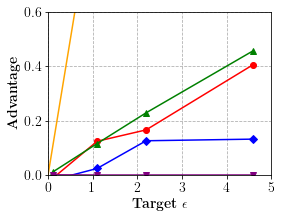

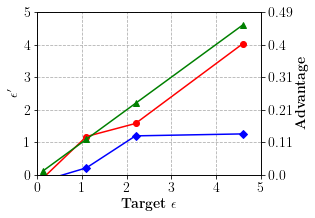

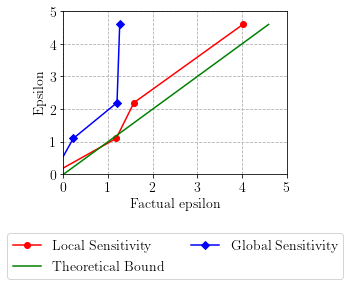

In [10]:
#avg_local = np.amax(max_biased_beliefs_bounded_local)
#avg_global = np.amax(max_biased_beliefs_bounded_global)

#local_vals = np.array([advantage_local_rho_52, advantage_local_rho_75, advantage_local_rho_90, advantage_local_rho_99])
#global_vals = np.array([advantage_global_rho_52, advantage_global_rho_75, advantage_global_rho_90, advantage_global_rho_99])

adv_local_adult = []
adv_global_adult = []
posterior_evaluate = ["rho_53_local_bound", 'rho_53_global_bound', "rho_75_local_bound", "rho_75_global_bound", "rho_90_local_bound", "rho_90_global_bound", "rho_99_local_bound", "rho_99_global_bound"]

for directory in posterior_evaluate:
    if f"local" in directory:
        adv_local_adult.append(adult_dict[f'advantage_adult_{directory}'])
    else:
        adv_global_adult.append(adult_dict[f'advantage_adult_{directory}'])

rhos = [0.53, .75, .9, .99]
delt=0.001
epsilons = [np.log(rho/(1-rho)) for rho in rhos]

eps_cont = np.arange(0, 1, 0.01)
adv_cont = [2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1 for eps in epsilons]

#print(adv_cont)
#print(local_vals)
#print(global_vals)

fig, ax = plt.subplots(1, figsize=(4,3))

# ax2 = ax.twinx()
#ax.callbacks.connect("ylim_changed", convert_ax_c_to_celsius)
ax.set_ylim(-0.0,0.6)
ax.plot(epsilons, np.array(adv_local_adult), 'ro', color='red', label='LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
#ax2.set_yscale('log')
ax.axis([0, 4, -0.0, 0.6])
ax.plot(epsilons, adv_cont, 'ro', color='green', label='Bound',marker='^', linestyle='-')
ax.plot(epsilons, np.array(adv_global_adult), 'ro', color='blue', label='GS',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

epsilons_yeom_bound = [0,1,2,3,4,5]
advantage_yeom = np.minimum(1,np.exp(epsilons_yeom_bound)-1)
ax.plot(epsilons_yeom_bound, np.array(advantage_yeom), 'ro', color='orange', label='Yeom\'s Bound',marker='', linestyle='-')

adult_advantages = [0.0007500000000000007, 0.0, 0.0, 5.000000000000004e-05]
# mi_empirical_eps = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adult_advantages)]
ax.plot(epsilons, adult_advantages, 'ro', color='purple', label=r'MI',marker='v', linestyle='-')


ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=(r'\textbf{Advantage}'))
#listcomprehension
# ax2.set_yticks(range(0,4))
# ticks_rhos = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in [0, 0.2,0.4,0.6]]
# ax2.set_yticklabels(ticks_rhos)
ax.set_xticks(range(0,6))
ax.set_xticks(range(0,6))
# ax.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))



# ax2.set_ylabel('Factual epsilon')
#ax2.tick_params('y')
#ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2.plot(epsilons, epsilons,'x',markersize=20, label = 'test')

plt.savefig("MI_comparison_adult.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()
#------------------------------------------------------

empirical_eps_local = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adv_local_adult)]
empirical_eps_global = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adv_global_adult)]

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(epsilons, empirical_eps_local, 'ro', color='red', label=r'LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons, epsilons, 'ro', color='green', label='Bound', marker='^', linestyle='-')
ax.plot(epsilons, empirical_eps_global, 'ro', color='blue', label=r'GS',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

advs = [np.around(2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1, 2) for eps in [0,1,2,3,4,5]]
yeom_bound2 = np.log(np.array(advs)+1)
# ax.plot([0,1,2,3,4,5], factual_eps_yeom, 'ro', color='orange', label=r'Yeom Bound',marker='', linestyle='-')


 
# adult_advantages = [0.0007500000000000007, 0.0, 0.0, 5.000000000000004e-05]
# mi_empirical_eps = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adult_advantages)]
# ax.plot(epsilons, mi_empirical_eps, 'ro', color='purple', label=r'MI',marker='v', linestyle='-')

ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=r"$\epsilon'$")
ax.set_xticks(range(0,6))
# plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

advs = [np.around(2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1, 2) for eps in [0,1,2,3,4,5]]
ax2 = ax.twinx()
ax2.set_yticks(range(0,6))
ticks_rhos = advs
ax2.set_yticklabels(ticks_rhos)
ax2.set_ylabel(r'\textbf{Advantage}')

plt.savefig("factual_eps_from_adv_adult.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()
#------------------------------------------------------
fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(empirical_eps_local, epsilons,  'ro', color='red', label=r'Local Sensitivity',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons_cont, epsilons_cont, 'ro', color='green', label='Theoretical Bound', marker='', linestyle='-')
ax.plot(empirical_eps_global, epsilons, 'ro', color='blue', label=r'Global Sensitivity',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

ax.set(xlabel='Factual epsilon', ylabel=r'Epsilon')
ax.set_xticks(range(0,6))
plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

#plt.savefig("local_sensitivity.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()

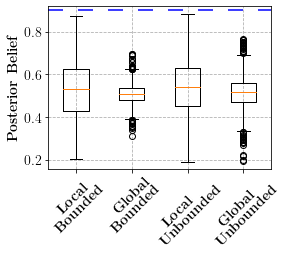

In [11]:
data_to_plot = []
beliefs_eval = ["rho_90_local_bound", "rho_90_global_bound", "rho_90_local_unbound", "rho_90_global_unbound"]

for directory in beliefs_eval:
    data_to_plot.append(adult_dict[f'max_biased_beliefs_adult_{directory}'])


fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.grid(ls="dashed")
plt.xticks(rotation=45)
ax.set_xticklabels([r'\textbf{Local \\ Bounded}', r'\textbf{Global \\ Bounded}', r'\textbf{Local \\ Unbounded}', r'\textbf{Global \\ Unbounded}'])
ax.axhline(y=0.9, ls="dashed", color="blue", dashes=(10, 10))
ax.set_ylabel(r"\textbf{Posterior Belief}")
plt.savefig("belief_boxplot_adult.pdf", bbox_inches='tight')
plt.show()

[0.49990845 0.49993896 0.49993896 ... 3.0000155  3.0000162  3.0000181 ]
[0.49990845 0.49993896 0.49993896 ... 3.0000155  3.0000162  3.0000181 ]
30000


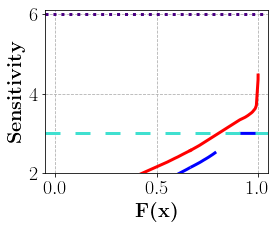

In [12]:
plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 20})

#X  = np.arange(0,1, 0.000033534540576794097920858484)
X  = np.arange(0,1, 1.0/len(np.array(adult_dict['sensitivities_rho_90_local_unbound']).flatten()))#0.00003333333333333333333333333)
CY = np.sort(np.array(adult_dict['sensitivities_rho_90_local_unbound']).flatten())
print(CY)
#CY /= CY[-1]
print(CY)
print(len(CY))
#data_to_plot = [np.array(sensitivities_bounded_local).flatten(), np.array(sensitivities_unbounded_local).flatten()]
fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_ylim(2,6.1)
# Create the boxplot
#bp = ax.boxplot(data_to_plot)
bp = ax.plot(X, CY,linewidth=3, color="blue", ls="dashed",dashes=(10, 10), label=r'$LS_g(D)$, U')

X  = np.arange(0,1, 1.0/len(np.array(adult_dict['sensitivities_rho_90_local_bound']).flatten()))#0.000033534540576794097920858484)
CY = np.sort(np.array(adult_dict['sensitivities_rho_90_local_bound']).flatten())
#CY /= CY[-1]
data_to_plot = [np.array(adult_dict['sensitivities_rho_90_local_bound']).flatten(), np.array(adult_dict['sensitivities_rho_90_local_unbound']).flatten()]
# Create an axes instance
#ax.set_ylim(2,6.1)
# Create the boxplot
#bp = ax.boxplot(data_to_plot)
bp2 = ax.plot(X, CY, linewidth=3,color="red", label=r'$LS_g(D)$, B')

ax.grid(ls="dashed")
#ax.set_xticklabels([r'Local Bounded', r'Local Unbounded'])
ax.axhline(y=3, ls="dashdot", linewidth=3,color="turquoise",dashes=(5, 5),  label=r'$C$ , U')
ax.axhline(y=6, ls="dotted",linewidth=3, color="indigo",  label=r'$2C$, B')
ax.set_ylabel(r"\textbf{Sensitivity}")
ax.set_xlabel(r"\textbf{F(x)}")
# plt.legend(loc=10, ncol=1, bbox_to_anchor=(0.5, -0.7))
plt.savefig("local_sensitivity_adult.pdf", bbox_inches='tight')
plt.show()

In [13]:


def compute_heterogenous_rdp(sampling_probabilities, noise_multipliers,
                             steps_list, orders):
    rdp = 0
    for q, noise_multiplier, steps in zip(sampling_probabilities, noise_multipliers, steps_list):
        rdp += compute_rdp(q, noise_multiplier, steps, orders)

    return rdp

def compute_rdp_eps_and_order(noise_multipliers, epochs, delta):
        orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
        #print(orders)
        sampling_probability = 1.0
        rdp = compute_heterogenous_rdp(sampling_probability*np.ones(epochs),
                          noise_multipliers=noise_multipliers,
                          steps_list= np.ones(epochs),
                          orders=orders)

        rdp_eps, _, order = get_privacy_spent(orders, rdp, target_delta=delta)
        return rdp_eps, order

In [14]:
composed_delta=0.001
rhos = [0.53, 0.75, 0.9, 0.99]

epochs = 30
clipping_norm = 6
#alpha = 7.8#17
rdp_eps = []
factual_eps = []
mean_eps = []


to_evaluate = ["rho_53_local_bound", "rho_75_local_bound", "rho_99_local_bound",  "rho_90_local_bound"]

for directory, rho in zip(to_evaluate, rhos):
    composed_eps = np.log(rho/(1-rho))
    print(composed_eps)
    original_mult = adversary.get_noise_multiplier_for_rdp_eps(composed_eps, composed_delta, epochs)
    mults = original_mult*np.ones(epochs)
    for sensitivities in adult_dict[f'sensitivities_{directory}']:
        noise_mult = np.array([original_mult*clipping_norm/local for local in sensitivities])

        epsilon, order = compute_rdp_eps_and_order(noise_mult, epochs, composed_delta)
        factual_eps.append(epsilon)
    mean_eps.append(np.max(factual_eps))
    print(np.mean(factual_eps))


0.12014431184206341
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fd0c99710e0>
0.11250088078514231
1.0986122886681098
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fd0c23890e0>
0.2506913188039071
2.1972245773362196
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fd0c23890e0>
0.4413225216620447
4.595119850134589
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fd0c23890e0>
0.7308074081286694


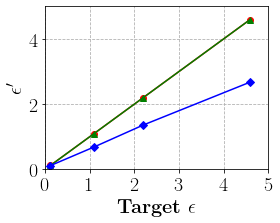

In [15]:
fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(epsilons, epsilons, 'ro', color='red', label=r'LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons, epsilons, 'ro', color='green', label='Bound', marker='^', linestyle='-')
ax.plot(epsilons, mean_eps, 'ro', color='blue', label=r'GS',marker='D', linestyle='-')

#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=r"$\epsilon'$")
ax.set_xticks(range(0,6))
# ax.set_xticks(range(0,6))
# plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

plt.savefig("factual_eps_sensitivities_adult_max.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()